# Week 7

This week, we cover two topics:

* Keras -- an API for the TensorFlow framework that offers easy ways to deploy neural models with GPU-accelerated training
* Convolutional neural networks (CNNs) -- a type of neural network that replaces the fully-connected hidden layers with so-called convolutional layers

CNNs provide much better performance on data with local structure like images, videos, and time series. They are sometimes used with audio and text as well.

# Lecture 12 - Oct 4 - Keras

Since computation is a bottleneck for neural nets, it is worthwhile to learn to construct neural nets with a dedicated deep learning framework rather than simply raw Python with NumPy, as we have used so far, because they allow highly optimized computation accelerated by graphics processing units (GPUs) and let us create nets quickly and easily.

As of now, the most popular solutions are Meta's PyTorch and Google's TensorFlow with Keras. (There are some other solutions like Theano, Caffe, and MXNet as well.) Both have two main parts: (1) highly optimized tensor computing, including matrix multiplication and (2) simple functionality for creating neural networks with optimized backpropagation.

We will use Keras/TensorFlow today.

## GPU Computing

Neural networks benefit from parallelization with GPUs, and TensorFlow can handle this for us. A GPU can be in your local device or in a cloud. The following code can check if TensorFlow sees a GPU.

In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

Num GPUs Available:  1
/device:GPU:0
device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


If there is a GPU on the device running the notebook, this prints the name of it. Otherwise, it prints that there are no GPUs available. (Note that, for TensorFlow to see and use a GPU in your local device, you must install NVIDIA's CUDA parallel computing platform and some drivers.)

TensorFlow, on which Keras is built, automatically exploits GPU resources quite efficiently, so it's not something that requires extra effort on our side. This means we have several layers of abstraction: Keras makes calls to TensorFlow, which makes calls to CUDA, which runs on C/C++. So, it is unrealistic to expect the whole path makes *everything* run optimally with absolute maximum efficiency, but, in practice, it is pretty close! However, I did want to point out that it can be worthwhile to customize lower-level code with TensorFlow or manage parallelization with raw CUDA code. None of this is particularly difficult, and CUDA customization is usually unnecessary, but it can be done.

### Writing a Fully-connected Feedforward Neural Net with Keras

We will aim to write a neural net similar to what we have constructed through the course so far. That is, it should feed data forward through a sequence of layers, the layers should be fully connected (dense), and we should use SGD to optimize it. We can import these things directly from Keras.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report

Let's construct the net to classify MNIST (our beloved benchmarking dataset) on a vanilla neural network (SGD, sigmoid, SSE loss) with two hidden layers

In [2]:
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, activation = 'sigmoid', input_shape=(784,))) # hidden layer 1
model.add(Dense(128, activation = 'sigmoid')) # hidden layer 2
model.add(Dense(10, activation = 'sigmoid')) # output layer

# compile the model by choosing how the optimizer works
model.compile(loss = 'mean_squared_error', optimizer = SGD(0.5), metrics = ['accuracy'])

# print a summary of the model
model.summary()

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Now, let's read in MNIST

In [3]:
# read in full MNIST
(trainX, trainY), (testX, testY) = mnist.load_data()

# reshape into vectors
trainX = trainX.reshape((trainX.shape[0], 28 * 28))
testX = testX.reshape((testX.shape[0], 28 * 28))

# scale the data to [0,1]
trainX = trainX/255.0
testX = testX/255.0

# convert the labels to one-hot form
trainY = to_categorical(trainY)
testY = to_categorical(testY)

Next, let's classify MNIST with our vanilla net.

Epoch 1/20
469/469 [==============================] - 5s 8ms/step - loss: 0.0901 - accuracy: 0.1808 - val_loss: 0.0887 - val_accuracy: 0.2372
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0879 - accuracy: 0.2612 - val_loss: 0.0868 - val_accuracy: 0.3296
Epoch 3/20
469/469 [==============================] - 4s 9ms/step - loss: 0.0850 - accuracy: 0.2924 - val_loss: 0.0823 - val_accuracy: 0.3264
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0786 - accuracy: 0.3994 - val_loss: 0.0741 - val_accuracy: 0.5206
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.0702 - accuracy: 0.5319 - val_loss: 0.0654 - val_accuracy: 0.5886
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0612 - accuracy: 0.6219 - val_loss: 0.0564 - val_accuracy: 0.6741
Epoch 7/20
469/469 [==============================] - 4s 8ms/step - loss: 0.0532 - accuracy: 0.6980 - val_loss: 0.0494 - val_accuracy: 0.7416
Epoch 

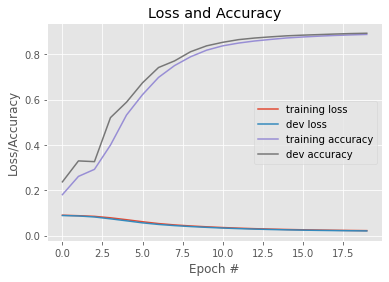

In [4]:
# fit the model to the training data
maxEpoch = 20
H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpoch, batch_size = 128)

print('Test accuracy')

# predict posterior probability distribution for labels of the test set
predictedY = model.predict(testX)

# convert posterior probabilities to labels
predictedY = predictedY.argmax(axis = 1)
realY = testY.argmax(axis = 1)

# print classification report
print(classification_report(realY, predictedY))

# plot the loss and accuracy through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title('Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

Let's try a more modern version using ReLU and softmax layers with categorical crossentropy loss, the ADAM optimizer, and both $L^1$ and $L^2$ regularization.

In [24]:
# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, input_shape = (784,), activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.0001)))
model.add(Dense(128, activation = 'relu', kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.0001)))
model.add(Dense(10, activation = 'softmax', kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.0001)))

# compile the model by choosing how the optimizer works
model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])

# print a summary of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               200960    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


Let's use this more modern network to classify MNIST

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.3224 - accuracy: 0.9239 - val_loss: 0.1693 - val_accuracy: 0.9630
Epoch 2/20
469/469 [==============================] - 2s 3ms/step - loss: 0.1543 - accuracy: 0.9691 - val_loss: 0.1396 - val_accuracy: 0.9720
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1216 - accuracy: 0.9779 - val_loss: 0.1201 - val_accuracy: 0.9784
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.1046 - accuracy: 0.9831 - val_loss: 0.1161 - val_accuracy: 0.9797
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0942 - accuracy: 0.9864 - val_loss: 0.1325 - val_accuracy: 0.9725
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0889 - accuracy: 0.9878 - val_loss: 0.1227 - val_accuracy: 0.9757
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.0829 - accuracy: 0.9898 - val_loss: 0.1175 - val_accuracy: 0.9789
Epoch 

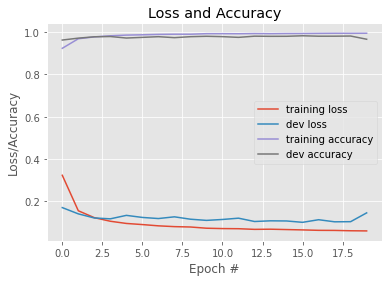

In [25]:
# fit the model to the training data
maxEpoch = 20
H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpoch, batch_size = 128)

print('Test accuracy')

# predict posterior probability distribution for labels of the test set
predictedY = model.predict(testX)

# convert posterior probabilities to labels
predictedY = predictedY.argmax(axis = 1)
realY = testY.argmax(axis = 1)

# print classification report
print(classification_report(realY, predictedY))

# plot the loss and accuracy through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title('Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

As expected, this is a little better.

### Writing a Fully-connected Feedforward Neural Net with Keras

We will aim to write a neural net similar to what we have constructed through the course so far. That is, it should feed data forward through a sequence of layers, the layers should be fully connected (dense), and we should use SGD to optimize it. We can import these things directly from Keras.

## Dropout, ADAM, etc.

A couple of features we learned about but never implemented in class are built into Keras, such as dropout (for regularization) and the ADAM optimizer, which adapts the learning rates to each parameter in an often-effective way.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
469/469 [===========================

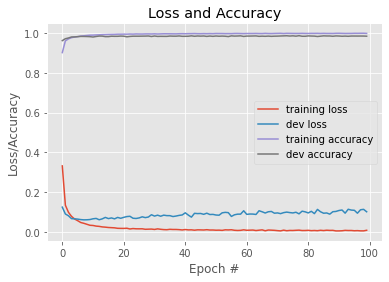

In [ ]:
# read in full MNIST
(trainX, trainY), (testX, testY) = mnist.load_data()

# reshape into vectors
trainX = trainX.reshape((trainX.shape[0], 28 * 28 * 1))
testX = testX.reshape((testX.shape[0], 28 * 28 * 1))

# scale the data to [0,1]
trainX = trainX/255.0
testX = testX/255.0

# convert the labels to one-hot form
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# Create a feedforward neural net
model = Sequential()

# Create the layers
model.add(Dense(256, activation = 'relu', input_shape=(trainX.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))

# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# print a model summary
model.summary()

# fit the model to the training data
maxEpoch = 100
H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpoch, batch_size = 128)

print('Test accuracy')

# predict posterior probability distribution for labels of the test set
predictedY = model.predict(testX)

# convert posterior probabilities to labels
predictedY = predictedY.argmax(axis = 1)
realY = testY.argmax(axis = 1)

# print classification report
print(classification_report(realY, predictedY))

# plot the loss and accuracy through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title('Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

## The CIFAR-10 Dataset

The CIFAR-10 dataset includes 60,000 colored images of size 32-by-32 pixels. Each pixel of the image has a red, a green, and a blue value, so the dimension of each image is 32 x 32 x 3 = 3072, where each RGB value of each pixel is a number between 0 and 255.

The images are classified as one of 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, or truck.

<img src = 'cifar10.png' />


By looking at some of the images, it should become clear that using an algorithm to classify this dataset should be significantly harder than classifying MNIST because there is much more variation in images within each class than in MNIST.

In [5]:
from tensorflow.keras.datasets import cifar10 

cifarData = cifar10.load_data()

# 1st index: training [0] and testing [1] data and labels
# 2nd index: datapoints [0] and labels [1]
# 3rd index: image from the set (0-49999) for training and (0-9999) for testing
# 4th index: column of RGB triples for pixels in column (0-32)
# 5th index: RGB triple for each pixel in column (0-32)
# 6th index: R for pixel, G for pixel, B for pixel (0-2)

In [18]:
cifarData[0][0][0][0][0][2]

63

The label is [6]


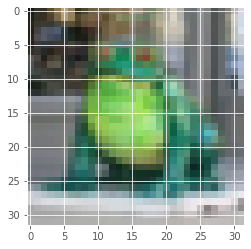

In [19]:
# DISPLAY MNIST PICTURES, DATA ARRAYS, AND LABELS
from IPython.display import clear_output
from keyboard import wait

for counter in range(20):
    pictureData = cifarData[0][0][counter]
    # plot the datapoints and their labels
    print('The label is', cifarData[0][1][counter])
    #print(pictureData)

    # plot the image
    plt.imshow(pictureData)
    plt.show()
    
    # wait until user presses 'q'
    wait('q')
    
    # clear the input
    clear_output(wait=True)

In [28]:
cifarData[0][0][:1000].shape

(1000, 32, 32, 3)

In [29]:
# read in full CIFAR-10 dataset
(trainX, trainY), (testX, testY) = cifar10.load_data()

# reshape into vectors
trainX = trainX.reshape((trainX.shape[0], 32 * 32 * 3))
testX = testX.reshape((testX.shape[0], 32 * 32 * 3))

# scale the data to [0,1]
trainX = trainX/255.0
testX = testX/255.0

# convert the labels to one-hot form
trainY = to_categorical(trainY)
testY = to_categorical(testY)

# initialize the label names for the CIFAR-10 dataset
labelNames = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Epoch 1/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.8651 - accuracy: 0.3279 - val_loss: 1.7543 - val_accuracy: 0.3682
Epoch 2/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.6711 - accuracy: 0.4007 - val_loss: 1.5904 - val_accuracy: 0.4269
Epoch 3/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5939 - accuracy: 0.4292 - val_loss: 1.5907 - val_accuracy: 0.4290
Epoch 4/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5438 - accuracy: 0.4474 - val_loss: 1.5906 - val_accuracy: 0.4165
Epoch 5/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.5241 - accuracy: 0.4540 - val_loss: 1.5225 - val_accuracy: 0.4551
Epoch 6/30
1563/1563 [==============================] - 4s 3ms/step - loss: 1.4932 - accuracy: 0.4682 - val_loss: 1.5191 - val_accuracy: 0.4658
Epoch 7/30
1563/1563 [==============================] - 5s 3ms/step - loss: 1.4736 - accuracy: 0.4736 - val_loss: 1.5048 - val_accuracy:

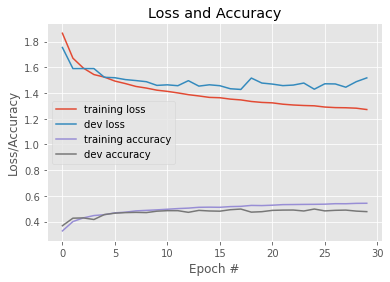

In [31]:
# define the 3072-256-128-10 architecture using Keras
model = Sequential()
model.add(Dense(256, input_shape = (3072,), activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit the model to the training data
maxEpoch = 30
H = model.fit(trainX, trainY, validation_data = (testX, testY), epochs = maxEpoch, batch_size = 32)

print('Test accuracy')

# predict posterior probability distribution for labels of the test set
predictedY = model.predict(testX)

# convert posterior probabilities to labels
predictedY = predictedY.argmax(axis = 1)
realY = testY.argmax(axis = 1)

# print classification report
print(classification_report(realY, predictedY))

# plot the loss and accuracy through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title('Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

As we will see, sometimes the simpler tools just do a better job!

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0898 - accuracy: 0.1750 - val_loss: 0.0875 - val_accuracy: 0.2640
Epoch 2/30
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0859 - accuracy: 0.2548 - val_loss: 0.0845 - val_accuracy: 0.2713
Epoch 3/30
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0832 - accuracy: 0.3003 - val_loss: 0.0821 - val_accuracy: 0.3050
Epoch 4/30
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0814 - accuracy: 0.3226 - val_loss: 0.0806 - val_accuracy: 0.3359
Epoch 5/30
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0801 - accuracy: 0.3373 - val_loss: 0.0795 - val_accuracy: 0.3530
Epoch 6/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0792 - accuracy: 0.3511 - val_loss: 0.0786 - val_accuracy: 0.3559
Epoch 7/30
1563/1563 [==============================] - 4s 3ms/step - loss: 0.0784 - accuracy: 0.3591 - val_loss: 0.0779 - val_accuracy:

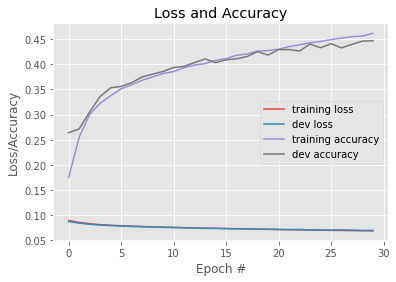

In [32]:
# define the 3072-256-128-10 architecture using Keras
model = Sequential()
model.add(Dense(256, input_shape = (3072,), activation = 'sigmoid'))
model.add(Dense(128, activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))

# train with SGD
opt = SGD(learning_rate = 0.05, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['accuracy'])

# train the model
maxEpoch = 30
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = maxEpoch, batch_size = 32)

print('Test accuracy')

# predict posterior probability distribution for labels of the test set
predictedY = model.predict(testX)

# convert posterior probabilities to labels
predictedY = predictedY.argmax(axis = 1)
realY = testY.argmax(axis = 1)

# print classification report
print(classification_report(realY, predictedY))

# plot the loss and accuracy through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title('Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

This works significantly better, but we see there is still a lot of overfitting. Maybe Dropout will help regularize the model.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/60
1563/1563 [==============================] - 6s 3ms/step - loss: 0.0913 - accuracy: 0.1179 - val_loss: 0.0887 - val_accuracy: 0.1978
Epoch 2/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0885 - accuracy: 0.1728 - val_loss: 0.0861 - val_accuracy: 0.2660
Epoch 3/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0863 - accuracy: 0.2119 - val_loss: 0.0841 - val_accuracy: 0.2911
Epoch 4/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0846 - accuracy: 0.2470 - val_loss: 0.0827 - val_accuracy: 0.3056
Epoch 5/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0835 - accuracy: 0.2702 - val_loss: 0.0816 - val_accuracy: 0.3075
Epoch 6/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0826 - accuracy: 0.2893 - val_loss: 0.0808 - val_accuracy: 0.3273
Epoch 7/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0818 - accuracy: 0.2999 - val_loss: 0.0801 - val_accuracy:

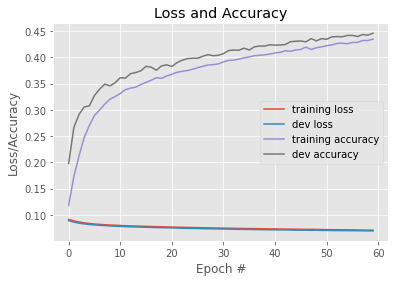

In [39]:
# define the 3072-256-128-10 architecture using Keras
model = Sequential()
model.add(Dense(256, input_shape = (3072,), activation = 'sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(10, activation = 'sigmoid'))

# train with SGD
opt = SGD(lr = 0.05, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['accuracy'])

# train the model
maxEpoch = 60
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = maxEpoch, batch_size = 32)

print('Test accuracy')

# predict posterior probability distribution for labels of the test set
predictedY = model.predict(testX)

# convert posterior probabilities to labels
predictedY = predictedY.argmax(axis = 1)
realY = testY.argmax(axis = 1)

# print classification report
print(classification_report(realY, predictedY))

# plot the loss and accuracy through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title('Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

It's also simple to implement different initializers, regularizers, etc. The code below doesn't result in great performance, but it does demonstrate these capabilities.

Epoch 1/60
1563/1563 [==============================] - 6s 3ms/step - loss: 0.0957 - accuracy: 0.1343 - val_loss: 0.0948 - val_accuracy: 0.2274
Epoch 2/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0938 - accuracy: 0.1917 - val_loss: 0.0926 - val_accuracy: 0.2014
Epoch 3/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0915 - accuracy: 0.2319 - val_loss: 0.0905 - val_accuracy: 0.2670
Epoch 4/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0897 - accuracy: 0.2675 - val_loss: 0.0888 - val_accuracy: 0.2881
Epoch 5/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0882 - accuracy: 0.2871 - val_loss: 0.0875 - val_accuracy: 0.3060
Epoch 6/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0872 - accuracy: 0.3053 - val_loss: 0.0865 - val_accuracy: 0.3230
Epoch 7/60
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0863 - accuracy: 0.3214 - val_loss: 0.0857 - val_accuracy:

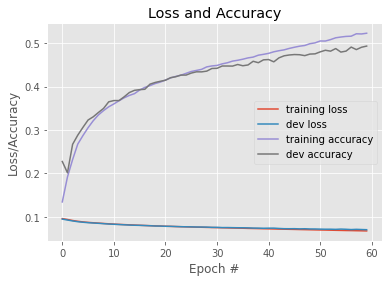

In [40]:
from tensorflow.keras.initializers import RandomUniform

# define the 3072-256-128-10 architecture using Keras
model = Sequential()
model.add(Dense(256,
                input_shape=(3072,),
                kernel_initializer = RandomUniform(minval=-0.1, maxval=0.1),
                bias_initializer = RandomUniform(minval=-0.1, maxval=0.1),
                kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000),
                bias_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000),
                activation="sigmoid"))

model.add(Dense(128, kernel_initializer = RandomUniform(minval=-0.1, maxval=0.1),
                kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000), bias_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000),
                bias_initializer = RandomUniform(minval=-0.1, maxval=0.1), activation="sigmoid"))

model.add(Dense(10, kernel_initializer = RandomUniform(minval=-0.1, maxval=0.1),
                bias_initializer = RandomUniform(minval=-0.1, maxval=0.1),
                kernel_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000), bias_regularizer = l1_l2(l1 = 0.0, l2 = 0.1/50000),
                activation="sigmoid"))

# train with SGD
opt = SGD(learning_rate = 0.05, momentum = 0.9)
model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['accuracy'])

# train the model
maxEpoch = 60
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs = maxEpoch, batch_size = 32)

print('Test accuracy')

# predict posterior probability distribution for labels of the test set
predictedY = model.predict(testX)

# convert posterior probabilities to labels
predictedY = predictedY.argmax(axis = 1)
realY = testY.argmax(axis = 1)

# print classification report
print(classification_report(realY, predictedY))

# plot the loss and accuracy through training
plt.style.use('ggplot')
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title('Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

## Lecture 13 - Oct 6 - CNNs and LeNet

We will now build toward the next big idea in neural networks: convolutional neural networks (frequently called CNNs or ConvNets). These are nets that take some inspiration from the way neurons are connected in an animal's visual cortex, where different groups of neurons respond to specific portions of the visual field and then those signals are combined in a sort of hierarchy that is thought to allow animals to extract increasingly complex features within the incoming visual stimuli.

CNNs are are feedforward neural networks like we have seen, but neurons in one layer are not necessarily connected to every neuron in the next layer. Such a more complex architecture, in some sense, allows a regularized version of fully-connected nets in that, they can generalize better to test data and to the real world. Recall, we could learn the whole training set for CIFAR-10 but had at least 30% less accuracy on test data.

Another benefit is that this more sparse sort of structure means we can build deeper or wider neural nets without growing the computation as much as fully-connected nets.

CNNs are some of the best algorithms for computer vision problems but have also been used effectively in anomaly detection, time series analysis in financial markets, and predicting the interactions between proteins and molecules in drug discovery among other applications. In particular, they are helpful wherever there is some kind of local structure within the datapoints.

(Please see the class notes for introductory material. We continue with implementing some CNNs.)

### Comparison with Fully-Connected Nets

A big difference between CNNs and the fully-connected nets we have seen is that there are far fewer parameters, which helps avoid overfitting. So, let's import some things from Keras and then create some nets to compare them.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import MaxPooling2D

In [2]:
# Create a fully-connected net and print a model summary
modelFC = Sequential(name = 'Fully Connected Net with shape [784, 100, 100, 10]')
modelFC.add(InputLayer(input_shape = (784,)))

modelFC.add(Dense(100))
modelFC.add(Activation('relu'))

modelFC.add(Dense(100))
modelFC.add(Activation('relu'))

modelFC.add(Dense(10))
modelFC.add(Activation('softmax'))

print(modelFC.summary())

Model: "Fully Connected Net with shape [784, 100, 100, 10]"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 activation_1 (Activation)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 89

In [3]:
# Create a CNN and print a model summary
modelCNN = Sequential(name = 'Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10]')

modelCNN.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNN.add(Activation('relu'))

modelCNN.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNN.add(Activation('relu'))

modelCNN.add(Flatten())

modelCNN.add(Dense(10))
modelCNN.add(Activation('softmax'))

print(modelCNN.summary())

Model: "Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10]"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 5)         50        
                                                                 
 activation_3 (Activation)   (None, 28, 28, 5)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 5)         230       
                                                                 
 activation_4 (Activation)   (None, 28, 28, 5)         0         
                                                                 
 flatten (Flatten)           (None, 3920)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                39210     
                                                                 
 activat

Now, we have about half as many parameters here for a pretty similar net in terms of learning capacity, but, more importantly, the parameters between two successive convolutional layers is absolutely tiny compared to successive dense layers, so CNNs not only overcome some overfitting issues, but are much more computationally friendly if our nets are deep.

Beyond that, CNNs usually have pooling layers that shrink the data after each convolutional layer, usually by taking the max of every distinct square sub-matrix of data coordinates (although there is average pooling, L2 pooling, and others). Quite common is to use a 2-by-2 block.

In [4]:
# Create a CNN with max pooling and print a model summary
modelCNNp = Sequential(name = 'Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10] and 2x2 max pooling' )

modelCNNp.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNNp.add(Activation('relu'))
modelCNNp.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

modelCNNp.add(Conv2D(5, (3, 3), padding = 'same', input_shape = (28, 28, 1)))
modelCNNp.add(Activation('relu'))
modelCNNp.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

modelCNNp.add(Flatten())

modelCNNp.add(Dense(10))
modelCNNp.add(Activation('softmax'))

print(modelCNNp.summary())

Model: "Convolutional net with shape [784, [5, 3x3], [5, 3x3], 10] and 2x2 max pooling"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 5)         50        
                                                                 
 activation_6 (Activation)   (None, 28, 28, 5)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 5)        0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 5)         230       
                                                                 
 activation_7 (Activation)   (None, 14, 14, 5)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 5)         

Here, we see the output from the pooling layers is only a fourth as large, which has no impact on the convolutional layers' parameters, but tremendously shrinks the parameters associated with the dense layer at the end, resulting in a model with only 2740 trainable parameters, about 85% less than without pooling layers.

### Implementing a Tiny CNN

Let's make a small CNN called ShallowNet just to get a sense of how to use Keras to build one and use it on some toy data.

In [5]:
class ShallowNet:
    # create the architecture
    def build(height, width, depth, numFilters, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with numFilters number of 3x3 filters
        model.add(Conv2D(numFilters, (3, 3), padding='same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        return model

Next, let's try to run it on MNIST

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 activation_15 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 10)                250890    
                                                                 
 activation_16 (Activation)  (None, 10)                0         
                                                                 
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training network...
Epoch 1/50
1500/

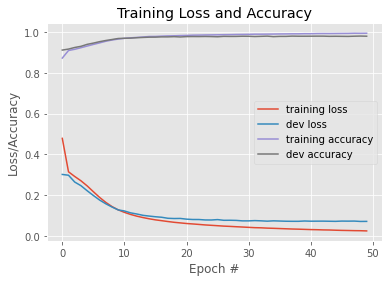

In [13]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(28, 28, 1, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxEpoch = 50
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 32, epochs = maxEpoch, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Let's try it with the Adam optimizer.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 activation_17 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 10)                250890    
                                                                 
 activation_18 (Activation)  (None, 10)                0         
                                                                 
Total params: 251,210
Trainable params: 251,210
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training network...
Epoch 1/20
1500/

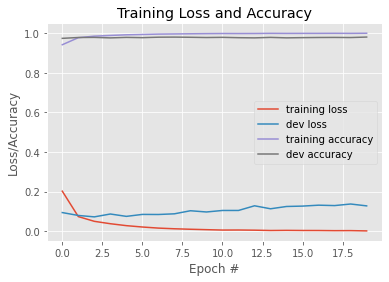

In [14]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(28, 28, 1, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxEpoch = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 32, epochs = maxEpoch, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Clearly, even this *tiny* CNN is amazing with MNIST, so let's try it on a harder problem: classifying CIFAR-10

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_19 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 flatten_7 (Flatten)         (None, 32768)             0         
                                                                 
 dense_10 (Dense)            (None, 10)                327690    
                                                                 
 activation_20 (Activation)  (None, 10)                0         
                                                                 
Total params: 328,586
Trainable params: 328,586
Non-trainable params: 0
_________________________________________________________________
None
[INFO] training network...
Epoch 1/20
313/3

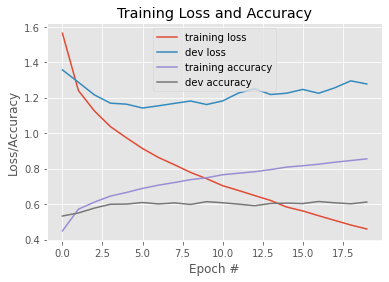

In [15]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = ShallowNet.build(32, 32, 3, 32, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

print("[INFO] training network...")
maxEpoch = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))
print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['loss'], label = 'training loss')
plt.plot(range(maxEpoch), H.history['val_loss'], label = 'dev loss')
plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

This is significantly better performance than we saw with fully-connected nets last week, reaching 60\% accuracy.

### LeNet

The first CNN that was considered particularly practical is what has become known as LeNet (named after Yann LeCun, who developed it along with his collaborators). The implementation below is a somewhat larger version of LeCun's net, which performs a bit better.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

class LeNet:
    # create the architecture
    def build(height, width, depth, classes):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same'))
        model.add(Activation('relu'))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

### LeNet for Classifying MNIST

Let's run the model on MNIST.

[INFO] training network...
Epoch 1/10
375/375 [==============================] - 4s 10ms/step - loss: 0.1561 - accuracy: 0.9506 - val_loss: 0.0641 - val_accuracy: 0.9815
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0394 - accuracy: 0.9874 - val_loss: 0.0388 - val_accuracy: 0.9887
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0259 - accuracy: 0.9916 - val_loss: 0.0333 - val_accuracy: 0.9899
Epoch 4/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0200 - accuracy: 0.9934 - val_loss: 0.0337 - val_accuracy: 0.9902
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0149 - accuracy: 0.9953 - val_loss: 0.0306 - val_accuracy: 0.9912
Epoch 6/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0112 - accuracy: 0.9966 - val_loss: 0.0329 - val_accuracy: 0.9915
Epoch 7/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0127 - accuracy: 0.9960 - val_loss: 0.0329

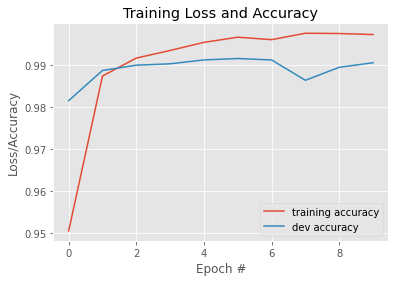

In [12]:
tf.keras.backend.clear_session()

(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNet.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxEpoch = 10
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch, verbose = 1)
print(model.summary())

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

LeNet is incredibly on MNIST, getting approximately 99.4\% test accuracy with zero tuning.

### LeNet for Classifying CIFAR-10

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 activation_5 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 activation_6 (Activation)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

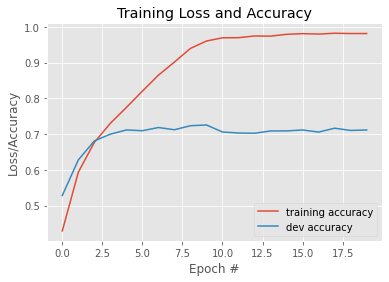

In [13]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNet.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print(model.summary())

print("[INFO] training network...")
maxEpoch = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We have now reached 70\% test accuracy on CIFAR-10, a gain of 20 percentage points since the previous lecture even though we have done nothing to tune the model!

Whats more, it took only 10 iterations with a runtime of about 21 seconds. This is partly due to the sparsity of CNNs and partially due to the Adam optimizer converging very quickly.

### Regularized LeNet

Let's try adding regularization in the form of $L^1$ and $L^2$ penalties and dropout to see if it helps the overfitting we see with both MNIST and CIFAR-10.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l1_l2

class LeNetReg:
    # create the architecture
    def build(height, width, depth, classes, lam1 = 0, lam2 = 0, dropout = [0, 0, 0, 0.5]):
        # create a feedforward neural net
        model = Sequential()
        
        # add a convolutional layer with 20 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(32, (5, 5), padding = 'same', input_shape = (height, width, depth),
                         kernel_regularizer = l1_l2(l1 = lam1, l2 = lam2)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(dropout[0]))
        
        # add another convolutional layer with 50 5x5 filters and a 2x2 max pooling layer
        model.add(Conv2D(64, (5, 5), padding= 'same', kernel_regularizer = l1_l2(l1 = lam1, l2 = lam2)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
        model.add(Dropout(dropout[1]))
        
        # add another convolutional layer
        model.add(Conv2D(128, (5, 5), padding = 'same', kernel_regularizer = l1_l2(l1 = lam1, l2 = lam2)))
        model.add(Activation('relu'))
        model.add(Dropout(dropout[2]))
        
        # add a fully-connected layer
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation('relu'))
        
        model.add(Dropout(dropout[3]))
        
        # add a softmax classifier
        model.add(Dense(classes))
        model.add(Activation('softmax'))
        
        # return the constructed model
        return model

Let's run it on MNIST to see if we can improve our (incredible) 99.4% accuracy!

[INFO] training network...
Epoch 1/10
375/375 [==============================] - 4s 10ms/step - loss: 0.1793 - accuracy: 0.9440 - val_loss: 0.0508 - val_accuracy: 0.9858
Epoch 2/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0465 - accuracy: 0.9852 - val_loss: 0.0388 - val_accuracy: 0.9877
Epoch 3/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0326 - accuracy: 0.9901 - val_loss: 0.0327 - val_accuracy: 0.9903
Epoch 4/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0238 - accuracy: 0.9924 - val_loss: 0.0339 - val_accuracy: 0.9899
Epoch 5/10
375/375 [==============================] - 4s 10ms/step - loss: 0.0181 - accuracy: 0.9943 - val_loss: 0.0354 - val_accuracy: 0.9912
Epoch 6/10
375/375 [==============================] - 4s 9ms/step - loss: 0.0154 - accuracy: 0.9953 - val_loss: 0.0443 - val_accuracy: 0.9905
Epoch 7/10
375/375 [==============================] - 3s 9ms/step - loss: 0.0121 - accuracy: 0.9963 - val_loss: 0.0312

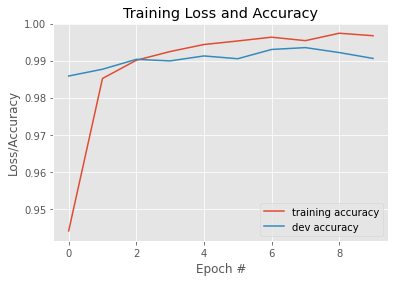

In [15]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainX = np.expand_dims(trainX, -1)
testX = np.expand_dims(testX, -1)

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(28, 28, 1, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxEpoch = 10
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

This is slightly worse, unfortunately, but the prior model was not really overfitting.

Let's try it with CIFAR-10, where we did observe overfitting.

[INFO] training network...
Epoch 1/10
313/313 [==============================] - 4s 12ms/step - loss: 1.6605 - accuracy: 0.3893 - val_loss: 1.3155 - val_accuracy: 0.5220
Epoch 2/10
313/313 [==============================] - 3s 11ms/step - loss: 1.2397 - accuracy: 0.5575 - val_loss: 1.1280 - val_accuracy: 0.6068
Epoch 3/10
313/313 [==============================] - 3s 11ms/step - loss: 1.0445 - accuracy: 0.6340 - val_loss: 0.9792 - val_accuracy: 0.6496
Epoch 4/10
313/313 [==============================] - 3s 11ms/step - loss: 0.9094 - accuracy: 0.6815 - val_loss: 0.8894 - val_accuracy: 0.6878
Epoch 5/10
313/313 [==============================] - 3s 11ms/step - loss: 0.7919 - accuracy: 0.7246 - val_loss: 0.8449 - val_accuracy: 0.7077
Epoch 6/10
313/313 [==============================] - 3s 11ms/step - loss: 0.6931 - accuracy: 0.7584 - val_loss: 0.8240 - val_accuracy: 0.7175
Epoch 7/10
313/313 [==============================] - 3s 11ms/step - loss: 0.6021 - accuracy: 0.7907 - val_loss: 0.

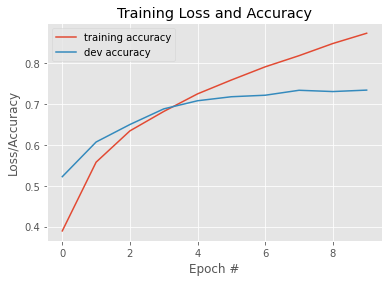

In [16]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print("[INFO] training network...")
maxEpoch = 10
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We see a slight improvement, up to 73\%. Let's go back to SGD and see how it compares.

[INFO] training network...
Epoch 1/50
313/313 [==============================] - 4s 11ms/step - loss: 2.1859 - accuracy: 0.1890 - val_loss: 2.0363 - val_accuracy: 0.2758
Epoch 2/50
313/313 [==============================] - 3s 10ms/step - loss: 1.9461 - accuracy: 0.3014 - val_loss: 1.9316 - val_accuracy: 0.3071
Epoch 3/50
313/313 [==============================] - 3s 10ms/step - loss: 1.7999 - accuracy: 0.3555 - val_loss: 1.6687 - val_accuracy: 0.4042
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 1.6827 - accuracy: 0.3950 - val_loss: 1.5996 - val_accuracy: 0.4306
Epoch 5/50
313/313 [==============================] - 3s 11ms/step - loss: 1.6154 - accuracy: 0.4223 - val_loss: 1.5471 - val_accuracy: 0.4496
Epoch 6/50
313/313 [==============================] - 3s 10ms/step - loss: 1.5489 - accuracy: 0.4447 - val_loss: 1.5067 - val_accuracy: 0.4664
Epoch 7/50
313/313 [==============================] - 3s 11ms/step - loss: 1.4993 - accuracy: 0.4642 - val_loss: 1.

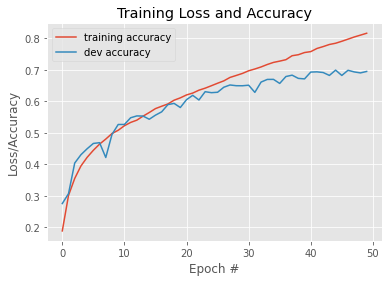

In [17]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10)
model.compile(loss = 'categorical_crossentropy', optimizer = SGD(0.01), metrics = ['accuracy'])

print("[INFO] training network...")
maxEpoch = 50
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch, verbose = 1)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

print(model.summary())

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We got worse results with SGD.

Some next steps might be to try regularization. Let's try weight decay (L1 and L2 penalties) since we are seeing overfitting.

In [9]:
from sklearn.metrics import accuracy_score

(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

best_hyperparameters = [0, 0]
best_accuracy = 0

for l1 in [0, 0.001, 0.01, 0.1]:
    for l2 in [0, 0.001, 0.01, 0.1]:
        
        model = LeNetReg.build(32, 32, 3, 10, l1/trainX.shape[0], l2/trainX.shape[0])
        model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

        maxIt = 20
        H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt, verbose = 0)
        dev_accuracy = H.history['val_accuracy'][-1]
        print('Dev accuracy for l1 =', l1, ', l2 =', l2, 'is', dev_accuracy)
        
        if dev_accuracy > best_accuracy:
            best_accuracy = dev_accuracy
            best_hyperparameters = [l1, l2]

Dev accuracy for l1 = 0 , l2 = 0 is 0.7315000295639038
Dev accuracy for l1 = 0 , l2 = 0.001 is 0.7386000156402588
Dev accuracy for l1 = 0 , l2 = 0.01 is 0.7275999784469604
Dev accuracy for l1 = 0 , l2 = 0.1 is 0.7336000204086304
Dev accuracy for l1 = 0.001 , l2 = 0 is 0.7297999858856201
Dev accuracy for l1 = 0.001 , l2 = 0.001 is 0.7293000221252441
Dev accuracy for l1 = 0.001 , l2 = 0.01 is 0.7347000241279602
Dev accuracy for l1 = 0.001 , l2 = 0.1 is 0.7386999726295471
Dev accuracy for l1 = 0.01 , l2 = 0 is 0.7400000095367432
Dev accuracy for l1 = 0.01 , l2 = 0.001 is 0.7293000221252441
Dev accuracy for l1 = 0.01 , l2 = 0.01 is 0.72079998254776
Dev accuracy for l1 = 0.01 , l2 = 0.1 is 0.7253999710083008
Dev accuracy for l1 = 0.1 , l2 = 0 is 0.7335000038146973
Dev accuracy for l1 = 0.1 , l2 = 0.001 is 0.7355999946594238
Dev accuracy for l1 = 0.1 , l2 = 0.01 is 0.7293999791145325
Dev accuracy for l1 = 0.1 , l2 = 0.1 is 0.7448999881744385


In [10]:
best_hyperparameters

[0.1, 0.1]

Epoch 1/15
313/313 [==============================] - 5s 12ms/step - loss: 1.6290 - accuracy: 0.4053 - val_loss: 1.3492 - val_accuracy: 0.5119
Epoch 2/15
313/313 [==============================] - 4s 11ms/step - loss: 1.1957 - accuracy: 0.5792 - val_loss: 1.0643 - val_accuracy: 0.6309
Epoch 3/15
313/313 [==============================] - 4s 11ms/step - loss: 0.9998 - accuracy: 0.6507 - val_loss: 0.9247 - val_accuracy: 0.6813
Epoch 4/15
313/313 [==============================] - 4s 11ms/step - loss: 0.8557 - accuracy: 0.7051 - val_loss: 0.8796 - val_accuracy: 0.6942
Epoch 5/15
313/313 [==============================] - 4s 11ms/step - loss: 0.7457 - accuracy: 0.7433 - val_loss: 0.8254 - val_accuracy: 0.7258
Epoch 6/15
313/313 [==============================] - 4s 11ms/step - loss: 0.6464 - accuracy: 0.7781 - val_loss: 0.8228 - val_accuracy: 0.7235
Epoch 7/15
313/313 [==============================] - 4s 11ms/step - loss: 0.5537 - accuracy: 0.8140 - val_loss: 0.8048 - val_accuracy: 0.7411

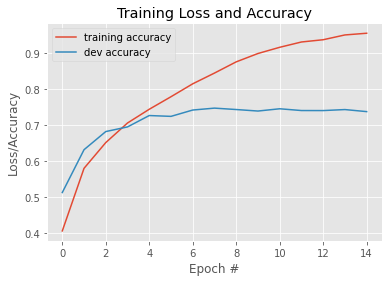

In [11]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10, 0.1/trainX.shape[0], 0.1/trainX.shape[0])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

maxEpoch = 15
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis = 1)
testY = testY.argmax(axis = 1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Here, we gained a couple percentage points, reaching 73.5\% test accuracy!

Let's try modifying the Dropout hyperparameters.

In [21]:
from sklearn.metrics import accuracy_score

(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

for dropout in [[0.1, 0.1, 0.1, 0.5], [0.2, 0.2, 0.2, 0.5], [0.5, 0.5, 0.5, 0.5]]:
        
    model = LeNetReg.build(32, 32, 3, 10, dropout = dropout)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    maxIt = 20
    H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxIt)
    print('Dev accuracy for dropout percentages', dropout, 'is', H.history['val_accuracy'][-1])

Epoch 1/20
313/313 [==============================] - 4s 12ms/step - loss: 1.6403 - accuracy: 0.3984 - val_loss: 1.3852 - val_accuracy: 0.5143
Epoch 2/20
313/313 [==============================] - 4s 11ms/step - loss: 1.2251 - accuracy: 0.5637 - val_loss: 1.0636 - val_accuracy: 0.6214
Epoch 3/20
313/313 [==============================] - 4s 11ms/step - loss: 1.0471 - accuracy: 0.6304 - val_loss: 0.9484 - val_accuracy: 0.6620
Epoch 4/20
313/313 [==============================] - 4s 11ms/step - loss: 0.9099 - accuracy: 0.6808 - val_loss: 0.8872 - val_accuracy: 0.6922
Epoch 5/20
313/313 [==============================] - 4s 11ms/step - loss: 0.8104 - accuracy: 0.7152 - val_loss: 0.8462 - val_accuracy: 0.7035
Epoch 6/20
313/313 [==============================] - 4s 11ms/step - loss: 0.7256 - accuracy: 0.7444 - val_loss: 0.8018 - val_accuracy: 0.7231
Epoch 7/20
313/313 [==============================] - 4s 11ms/step - loss: 0.6495 - accuracy: 0.7705 - val_loss: 0.7929 - val_accuracy: 0.7308

Dev accuracy jumped to 74.6\% by adding Dropout after the pooling layers.

Epoch 1/20
313/313 [==============================] - 4s 12ms/step - loss: 1.6881 - accuracy: 0.3760 - val_loss: 1.3542 - val_accuracy: 0.4989
Epoch 2/20
313/313 [==============================] - 4s 11ms/step - loss: 1.2797 - accuracy: 0.5422 - val_loss: 1.0909 - val_accuracy: 0.6045
Epoch 3/20
313/313 [==============================] - 4s 11ms/step - loss: 1.1001 - accuracy: 0.6093 - val_loss: 1.0672 - val_accuracy: 0.6290
Epoch 4/20
313/313 [==============================] - 4s 11ms/step - loss: 0.9714 - accuracy: 0.6599 - val_loss: 0.9288 - val_accuracy: 0.6759
Epoch 5/20
313/313 [==============================] - 4s 11ms/step - loss: 0.8876 - accuracy: 0.6899 - val_loss: 0.9192 - val_accuracy: 0.6852
Epoch 6/20
313/313 [==============================] - 4s 11ms/step - loss: 0.8065 - accuracy: 0.7155 - val_loss: 0.7884 - val_accuracy: 0.7260
Epoch 7/20
313/313 [==============================] - 4s 11ms/step - loss: 0.7428 - accuracy: 0.7391 - val_loss: 0.8094 - val_accuracy: 0.7228

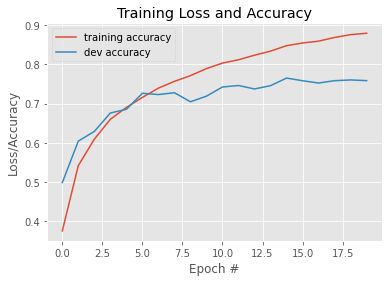

In [22]:
from sklearn.metrics import accuracy_score

(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

model = LeNetReg.build(32, 32, 3, 10, dropout = [0.2, 0.2, 0.2, 0.5])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

maxEpoch = 20
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis = 1)
testY = testY.argmax(axis = 1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

We improve even further to about 75\% test accuracy.

For a final test, let's try L1, L2, and enhanced dropout.

Epoch 1/50
313/313 [==============================] - 5s 13ms/step - loss: 1.7244 - accuracy: 0.3694 - val_loss: 1.3721 - val_accuracy: 0.5173
Epoch 2/50
313/313 [==============================] - 4s 12ms/step - loss: 1.3093 - accuracy: 0.5361 - val_loss: 1.1340 - val_accuracy: 0.6055
Epoch 3/50
313/313 [==============================] - 4s 12ms/step - loss: 1.1227 - accuracy: 0.6090 - val_loss: 1.0413 - val_accuracy: 0.6384
Epoch 4/50
313/313 [==============================] - 4s 12ms/step - loss: 1.0049 - accuracy: 0.6484 - val_loss: 0.9217 - val_accuracy: 0.6830
Epoch 5/50
313/313 [==============================] - 4s 12ms/step - loss: 0.9050 - accuracy: 0.6868 - val_loss: 0.8649 - val_accuracy: 0.6996
Epoch 6/50
313/313 [==============================] - 4s 12ms/step - loss: 0.8472 - accuracy: 0.7068 - val_loss: 0.8350 - val_accuracy: 0.7172
Epoch 7/50
313/313 [==============================] - 4s 12ms/step - loss: 0.7844 - accuracy: 0.7296 - val_loss: 0.8579 - val_accuracy: 0.7142

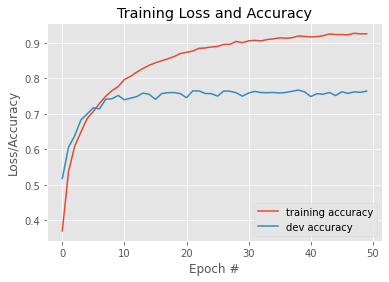

In [23]:
from sklearn.metrics import accuracy_score

(trainX, trainY), (testX, testY) = cifar10.load_data()

trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

n = trainX.shape[0]

model = LeNetReg.build(32, 32, 3, 10, lam1 = 0.1/n, lam2 = 0.1/n, dropout = [0.2, 0.2, 0.2, 0.5])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

maxEpoch = 50
H = model.fit(trainX, trainY, validation_split = 0.20, batch_size = 128, epochs = maxEpoch)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis = 1)
testY = testY.argmax(axis = 1)
print(classification_report(testY, predictedY))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(range(maxEpoch), H.history['accuracy'], label = 'training accuracy')
plt.plot(range(maxEpoch), H.history['val_accuracy'], label = 'dev accuracy')

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

The performance is still above 75\%, sometimes hitting 76\%, which is great!